/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:43:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Health Condition Prediction Performance Summary:

╒════════════════════════════════╤═════════╕
│ Metric                         │ Value   │
╞════════════════════════════════╪═════════╡
│ Accuracy                       │ 96.43%  │
├────────────────────────────────┼─────────┤
│ ADHD Precision                 │ 1.00    │
├────────────────────────────────┼─────────┤
│ ADHD Recall                    │ 0.50    │
├────────────────────────────────┼─────────┤
│ ADHD F1 Score                  │ 0.67    │
├────────────────────────────────┼─────────┤
│ ASD Precision                  │ 1.00    │
├────────────────────────────────┼─────────┤
│ ASD Recall                     │ 1.00    │
├────────────────────────────────┼─────────┤
│ ASD F1 Score                   │ 1.00    │
├────────────────────────────────┼─────────┤
│ Cognitive Impairment Precision │ 1.00    │
├────────────────────────────────┼─────────┤
│ Cognitive Impairment Recall    │ 0.97    │
├────────────────────────────────┼─────────┤
│ Co

<ipython-input-1-791eb0bf087f>:96: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df[['Timestamp', 'GSR', 'EMG', 'HealthCondition', 'PredictedHealthCondition']].style.applymap(


,Timestamp,GSR,EMG,HealthCondition,PredictedHealthCondition
0,2/1/2025 16:25:12,0.845238,0.332857,Cognitive Impairment,Cognitive Impairment
1,2/1/2025 16:25:23,0.892857,0.364286,Cognitive Impairment,Cognitive Impairment
2,2/1/2025 16:25:34,0.892857,0.285714,Cognitive Impairment,Cognitive Impairment
3,2/1/2025 16:25:46,0.892857,0.321429,Cognitive Impairment,Cognitive Impairment
4,2/1/2025 16:25:57,0.892857,0.357143,Cognitive Impairment,Cognitive Impairment
5,2/1/2025 16:26:08,0.892857,0.315714,Cognitive Impairment,Cognitive Impairment
6,2/1/2025 16:26:18,0.886905,0.354286,Cognitive Impairment,Cognitive Impairment
7,2/1/2025 16:26:30,0.892857,0.351429,Cognitive Impairment,Cognitive Impairment
8,2/1/2025 16:26:41,0.892857,0.315714,Cognitive Impairment,Cognitive Impairment
9,2/1/2025 16:26:55,0.886905,0.320000,Cognitive Impairment,Cognitive Impairment


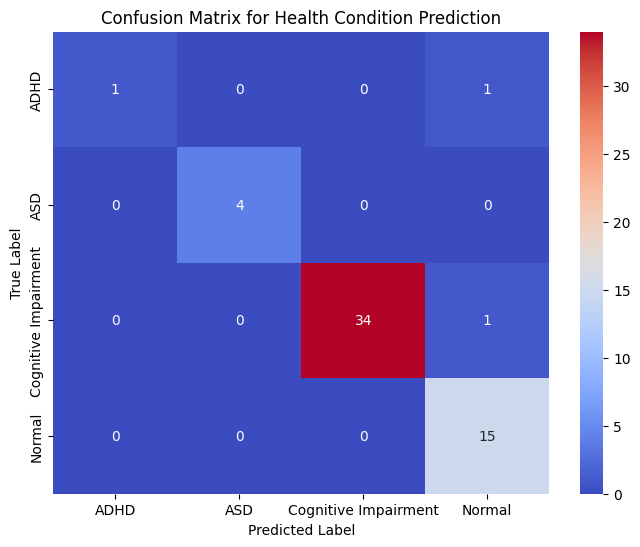

In [ ]:
# Disorder Prediction
import gspread
import pandas as pd
from google.colab import auth
from google.auth import default
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tabulate import tabulate
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

sheet_url = "https://docs.google.com/spreadsheets/d/1Eto7AfjxMDvJVw5Pq9YjRK_5VEatQUxU2SloIqug4eY/edit?gid=0#gid=0"  # Replace with your sheet URL
worksheet = gc.open_by_url(sheet_url).sheet1
data = worksheet.get_all_records()
df = pd.DataFrame(data)

df['GSR'] = pd.to_numeric(df['GSR'], errors='coerce').ffill().bfill()
df['EMG'] = pd.to_numeric(df['EMG'], errors='coerce').ffill().bfill()

# Normalize GSR and EMG
scaler = MinMaxScaler()
df[['GSR', 'EMG']] = scaler.fit_transform(df[['GSR', 'EMG']])

def label_health_condition(row):
    if row['GSR'] > 0.6 and row['EMG'] > 0.6:
        return "ASD"
    elif row['GSR'] > 0.5 and row['EMG'] < 0.5:
        return "Cognitive Impairment"
    elif row['GSR'] < 0.3 and row['EMG'] > 0.5:
        return "ADHD"
    # elif row['GSR'] > 0.4 and row['EMG'] > 0.4:
    #     return "PTSD/Trauma"
    else:
        return "Normal"

df['HealthCondition'] = df.apply(label_health_condition, axis=1)

# Oversampling (same as before)
for condition in df['HealthCondition'].value_counts().index:
    while df['HealthCondition'].value_counts()[condition] < 10:
        df = pd.concat([df, df[df['HealthCondition'] == condition]])

label_encoder = LabelEncoder()
df['HealthConditionEncoded'] = label_encoder.fit_transform(df['HealthCondition'])

X = df[['GSR', 'EMG']]
y = df['HealthConditionEncoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Display performance summary in a table
performance_data = [["Metric", "Value"], ["Accuracy", f"{accuracy * 100:.2f}%"]]
for condition, metrics in class_report.items():
    if isinstance(metrics, dict):
        performance_data.append([f"{condition} Precision", f"{metrics['precision']:.2f}"])
        performance_data.append([f"{condition} Recall", f"{metrics['recall']:.2f}"])
        performance_data.append([f"{condition} F1 Score", f"{metrics['f1-score']:.2f}"])

print("\nHealth Condition Prediction Performance Summary:\n")
print(tabulate(performance_data, headers="firstrow", tablefmt="fancy_grid"))

# Add model predictions to DataFrame for visualization
df['PredictedHealthCondition'] = label_encoder.inverse_transform(xgb_clf.predict(df[['GSR', 'EMG']]))

# Ensure unique indices to avoid errors in styling
df = df.reset_index(drop=True)

# Function to color-code health conditions in the table
def color_health_condition(val):
    if val == "ASD":
        return 'background-color: #FFCDD2; color: black'  # Light Red
    elif val == "Cognitive Impairment":
        return 'background-color: #BBDEFB; color: black'  # Light Blue
    elif val == "ADHD":
        return 'background-color: #FFF9C4; color: black'  # Light Yellow
    # elif val == "PTSD/Trauma":
    #     return 'background-color: #C8E6C9; color: black'  # Light Green
    else:
        return 'background-color: #E0E0E0; color: black'  # Light Gray for Normal

# Apply styling to display original and predicted conditions
styled_df = df[['Timestamp', 'GSR', 'EMG', 'HealthCondition', 'PredictedHealthCondition']].style.applymap(
    color_health_condition, subset=['HealthCondition', 'PredictedHealthCondition']).set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid black')]}
])

# Display the styled table
display(styled_df)

# Visualization: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Health Condition Prediction")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()